In [1]:
import numpy as np
import pandas as pd
import torch
from torch import nn, optim
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

## Fitting Change of Slope Models via Pytorch: importance of scaling

The following dataset is from \url{https://fred.stlouisfed.org/series/TLCOMCONS}. It is slightly different from the dataset used in Lecture 24 (which was \url{https://fred.stlouisfed.org/series/TTLCONS}).  

  observation_date  TLCOMCONS
0       2002-01-01      68254
1       2002-02-01      65840
2       2002-03-01      66722
3       2002-04-01      64879
4       2002-05-01      62741
5       2002-06-01      60982
6       2002-07-01      58971
7       2002-08-01      61223
8       2002-09-01      61997
9       2002-10-01      61772
    observation_date  TLCOMCONS
268       2024-05-01     126084
269       2024-06-01     125371
270       2024-07-01     124989
271       2024-08-01     125184
272       2024-09-01     125608
273       2024-10-01     124379
274       2024-11-01     125270
275       2024-12-01     125645
276       2025-01-01     124650
277       2025-02-01     125988


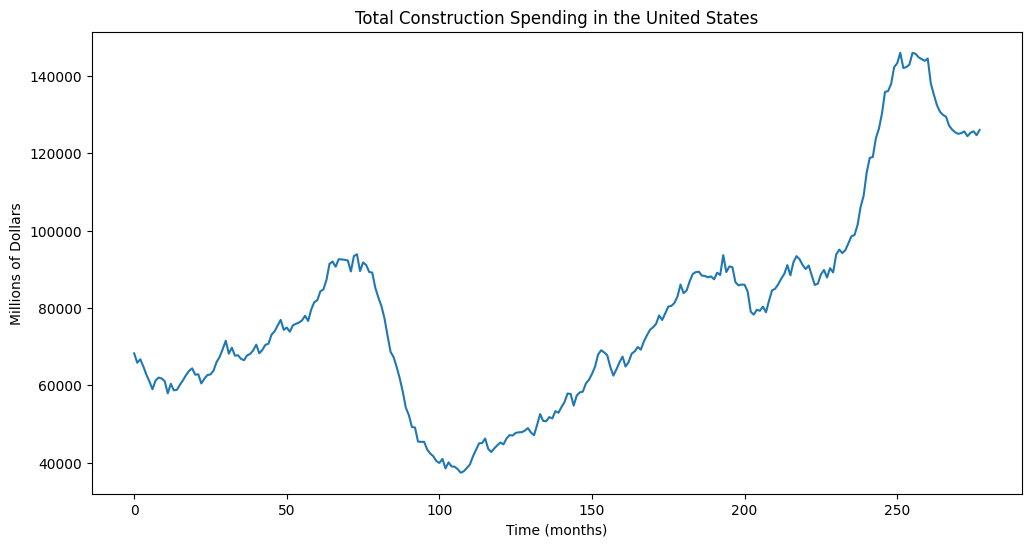

In [2]:
ttlcons = pd.read_csv('TLCOMCONS_23April2025.csv')
print(ttlcons.head(10))
print(ttlcons.tail(10))

y_raw = ttlcons['TLCOMCONS']
n = len(y_raw)
x_raw = np.arange(1, n+1)
plt.figure(figsize = (12, 6))
plt.plot(y_raw)
plt.xlabel("Time (months)")
plt.ylabel('Millions of Dollars')
plt.title("Total Construction Spending in the United States")
plt.show()

Let us try to fit the model: 
\begin{equation*}
  y_t = \beta_0 + \beta_1 t + \beta_2 (x_t - c_1)_+ + \beta_3 (x_t - c_2)_+ + \dots + \beta_{k+1} (x_t - c_k)_+ + \epsilon_t
\end{equation*}
where the unknown parameters are $\beta_0,\beta_1, \dots, \beta_{k+1}$ and $c_1, \dots, c_k$ (as well as $\sigma$ which is the noise level in $\epsilon_t \overset{\text{i.i.d}}{\sim} N(0, \sigma^2)$). We will fix a value of $k$. Here $x_t = t$. 

In PyTorch, this model can be coded as follows. 

In [3]:
class PiecewiseLinearModel(nn.Module):
    def __init__(self, knots_init, beta_init):
        super().__init__()
        self.num_knots = len(knots_init)
        self.beta = nn.Parameter(torch.tensor(beta_init, dtype=torch.float32)) 
        self.knots = nn.Parameter(torch.tensor(knots_init, dtype=torch.float32))
        # When a tensor is wrapped in nn.Parameter and assigned as an attribute to a nn.Module, 
        # it is automatically registered as a parameter of that module.

    def forward(self, x):
        knots_sorted, _ = torch.sort(self.knots)
        out = self.beta[0] + self.beta[1] * x
        for j in range(self.num_knots):
            out += self.beta[j + 2] * torch.relu(x - knots_sorted[j])
        return out

The parameters will be estimated simply by least squares i.e., by minimizing
\begin{equation*}
  \sum_{t=1}^n \left(y_t - \beta_0 - \beta_1 t - \beta_2 (x_t - c_1)_+ - \dots - \beta_{k+1} (x_t - c_k)_+ \right)^2 
\end{equation*}
This is possibly a non-convex minimization problem (note that we are optimizing over $c_1, \dots, c_k$ as well). The algorithm used will be gradient descent (or a variant such as Adam). Initialization will be important for the algorithm to work well and not get stuck in bad local minima. 

Here is how the least squares minimization is solved in PyTorch. The first step is to convert the data y_raw and x_raw into PyTorch tensors. 

In [4]:
y_raw_torch = torch.tensor(y_raw, dtype=torch.float32)
x_raw_torch = torch.tensor(x_raw, dtype=torch.float32)

The next step is to create suitable initialization. It is natural to take $c_1, \dots, c_k$ to be quantiles of $x_t$ at $1/(k+1), \dots, k/(k+1)$. For $\beta_0, \dots, \beta_{k+2}$, we run a linear regression with these initial $c_1, \dots, c_k$ and then take the corresponding coefficients.  

In [5]:
# First fix the number of knots
k = 4

quantile_levels = np.linspace(1/(k+1), k/(k+1), k)
knots_init = np.quantile(x_raw, quantile_levels)

n = len(y_raw)
X = np.column_stack([np.ones(n), x_raw])
for j in range(k):
    xc = ((x_raw > knots_init[j]).astype(float)) * (x_raw - knots_init[j])  
    X = np.column_stack([X, xc])
md_init = sm.OLS(y_raw, X).fit()
beta_init = md_init.params.values

print(knots_init)
print(beta_init)

[ 56.4 111.8 167.2 222.6]
[52167.91700846   628.19139706 -1505.22955093  1506.51113458
  -264.69041849   565.3087544 ]


Note that the values of these initial coeffficients $\beta_0, \dots, \beta_{k+2}$ are on different scales (for example, the intercept is much larger in magnitude compared to the other terms).  

Once the initial values are determined, we construct our model. 

In [6]:
# Define a model
md_nn = PiecewiseLinearModel(knots_init=knots_init, beta_init=beta_init)
# This code creates an instance of our custom neural network class. 
# It also initializes the knots at knots_init.

Now we shall run the optimization algorithm which starts with these initial estimates, and then iteratively updates them. The crucial hyperparameter  in the optimization algorithm is the learning rate (denoted by lr in the code below). This controls how much to adjust the parameters with respect to the gradient during each step of optimization. A smaller value means smaller steps, which can lead to more stable convergence but possibly slower training. A larger learning rate would update the parameters more aggressively, which might speed up training but risks overshooting the minimum.   

In [7]:
# Define an optimizer
optimizer = optim.Adam(md_nn.parameters(), lr=1) 

# Define a loss function
loss_fn = nn.MSELoss()

for epoch in range(300000): 
    # Zero gradients
    optimizer.zero_grad()
    # Without zeroing the gradients before each iteration, 
    # gradients from previous iterations would accumulate, 
    # leading to incorrect updates of the model's parameters.

    # Compute loss
    y_pred = md_nn(x_raw_torch)
    loss = loss_fn(y_pred, y_raw_torch)

    # Compute gradient
    loss.backward()
    # The .backward() method calculates the gradients of that tensor 
    # with respect to all the parameters in the network that contributed to its computation.  

    # Update parameters
    optimizer.step()
    # The .step() method performs a single optimization step, 
    # updating the model's parameters based on the gradients computed during the backward pass.

    if epoch % 100 == 0: 
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

Epoch 0, Loss: 80948888.0000
Epoch 100, Loss: 65042588.0000
Epoch 200, Loss: 60759240.0000
Epoch 300, Loss: 58784464.0000
Epoch 400, Loss: 57340764.0000
Epoch 500, Loss: 56138456.0000
Epoch 600, Loss: 55141832.0000
Epoch 700, Loss: 54289180.0000
Epoch 800, Loss: 53564112.0000
Epoch 900, Loss: 52947568.0000
Epoch 1000, Loss: 52399508.0000
Epoch 1100, Loss: 51928280.0000
Epoch 1200, Loss: 51474756.0000
Epoch 1300, Loss: 51121904.0000
Epoch 1400, Loss: 50800472.0000
Epoch 1500, Loss: 50423620.0000
Epoch 1600, Loss: 50204756.0000
Epoch 1700, Loss: 49875076.0000
Epoch 1800, Loss: 49650664.0000
Epoch 1900, Loss: 49435356.0000
Epoch 2000, Loss: 49242824.0000
Epoch 2100, Loss: 49061540.0000
Epoch 2200, Loss: 48901288.0000
Epoch 2300, Loss: 48751352.0000
Epoch 2400, Loss: 48609104.0000
Epoch 2500, Loss: 48480148.0000
Epoch 2600, Loss: 48369612.0000
Epoch 2700, Loss: 48246148.0000
Epoch 2800, Loss: 48140624.0000
Epoch 2900, Loss: 48050288.0000
Epoch 3000, Loss: 47964040.0000
Epoch 3100, Loss: 47

Here are some points that can be verified: 
1. When the learning rate is 0.01, the algorithm is moving too slowly and we get convergence after about 300000 epochs. 
2. When the learning rate is 0.1, the algorithm is still slow and convergence seems to be achieved at around 150000 epochs. 
3. When the learning rate is 1, the algorithm does not seem to settle down, and is oscillating quite a bit even after reaching around the smallest loss. 

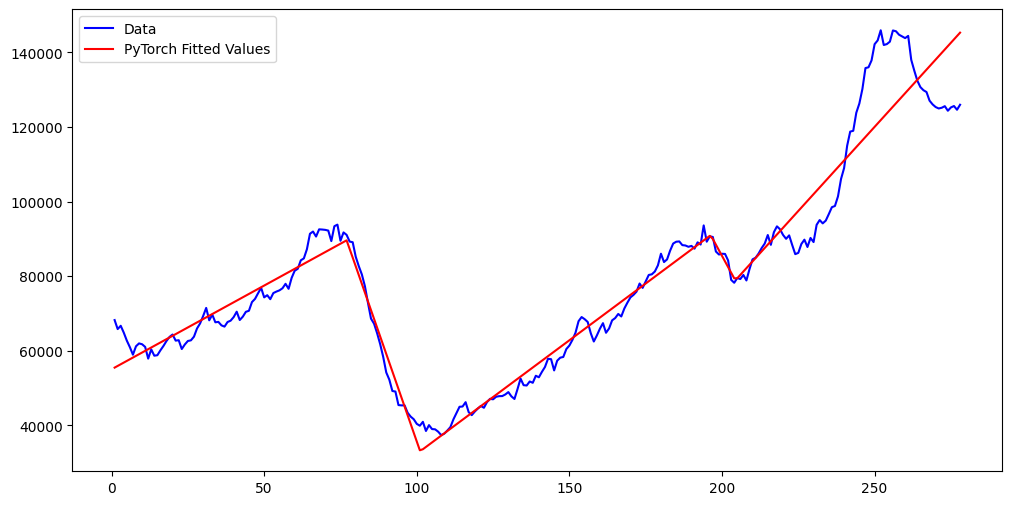

In [8]:
nn_fits = md_nn(x_raw_torch).detach().numpy()
# detach() in PyTorch creates a new tensor that shares the same storage as the original tensor 
# but is detached from the computation graph. 

plt.figure(figsize = (12, 6))
plt.plot(x_raw, y_raw, color = 'blue', label = 'Data')
plt.plot(x_raw, nn_fits, color = 'red', label = 'PyTorch Fitted Values')
plt.legend()
plt.show()

Now we shall scale the covariates $x_t$ and $y_t$, and then run the same algorithm again.

In [9]:
y_scaled = (y_raw - np.mean(y_raw)) / (np.std(y_raw))
x_scaled = (x_raw - np.mean(x_raw)) / (np.std(x_raw))

y_torch = torch.tensor(y_scaled, dtype=torch.float32)
x_torch = torch.tensor(x_scaled, dtype=torch.float32)

In [10]:
# First fix the number of knots
k = 4

quantile_levels = np.linspace(1/(k+1), k/(k+1), k)
knots_init = np.quantile(x_scaled, quantile_levels)

n = len(y_scaled)
X = np.column_stack([np.ones(n), x_scaled])
for j in range(k):
    xc = ((x_scaled > knots_init[j]).astype(float)) * (x_scaled - knots_init[j])  
    X = np.column_stack([X, xc])
md_init = sm.OLS(y_scaled, X).fit()

beta_init = md_init.params.values

print(knots_init)
print(beta_init)

[-1.03549894 -0.34516631  0.34516631  1.03549894]
[ 2.26579783  1.87350378 -4.48916248  4.49298465 -0.7894067   1.68596401]


Now the $\beta$ coefficients are of the same scale. 

In [11]:
md_nn = PiecewiseLinearModel(knots_init=knots_init, beta_init=beta_init)

In [12]:
optimizer = optim.Adam(md_nn.parameters(), lr=0.01)
loss_fn = nn.MSELoss()

for epoch in range(20000): 
    # Zero gradients
    optimizer.zero_grad()

    # Compute loss
    y_pred = md_nn(x_torch)
    loss = loss_fn(y_pred, y_torch)

    # Compute gradient
    loss.backward()

    # Update parameters
    optimizer.step()

    if epoch % 100 == 0: 
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

Epoch 0, Loss: 0.1118
Epoch 100, Loss: 0.0899
Epoch 200, Loss: 0.0809
Epoch 300, Loss: 0.0764
Epoch 400, Loss: 0.0739
Epoch 500, Loss: 0.0719
Epoch 600, Loss: 0.0704
Epoch 700, Loss: 0.0693
Epoch 800, Loss: 0.0684
Epoch 900, Loss: 0.0677
Epoch 1000, Loss: 0.0671
Epoch 1100, Loss: 0.0667
Epoch 1200, Loss: 0.0663
Epoch 1300, Loss: 0.0664
Epoch 1400, Loss: 0.0657
Epoch 1500, Loss: 0.0655
Epoch 1600, Loss: 0.0653
Epoch 1700, Loss: 0.0651
Epoch 1800, Loss: 0.0652
Epoch 1900, Loss: 0.0649
Epoch 2000, Loss: 0.0653
Epoch 2100, Loss: 0.0646
Epoch 2200, Loss: 0.0645
Epoch 2300, Loss: 0.0644
Epoch 2400, Loss: 0.0644
Epoch 2500, Loss: 0.0643
Epoch 2600, Loss: 0.0642
Epoch 2700, Loss: 0.0642
Epoch 2800, Loss: 0.0641
Epoch 2900, Loss: 0.0641
Epoch 3000, Loss: 0.0641
Epoch 3100, Loss: 0.0641
Epoch 3200, Loss: 0.0640
Epoch 3300, Loss: 0.0640
Epoch 3400, Loss: 0.0640
Epoch 3500, Loss: 0.0640
Epoch 3600, Loss: 0.0639
Epoch 3700, Loss: 0.0639
Epoch 3800, Loss: 0.0639
Epoch 3900, Loss: 0.0639
Epoch 4000, 

Now the convergence is much faster (after about 8000 iterations). Let us plot the fitted values on the original scale. 

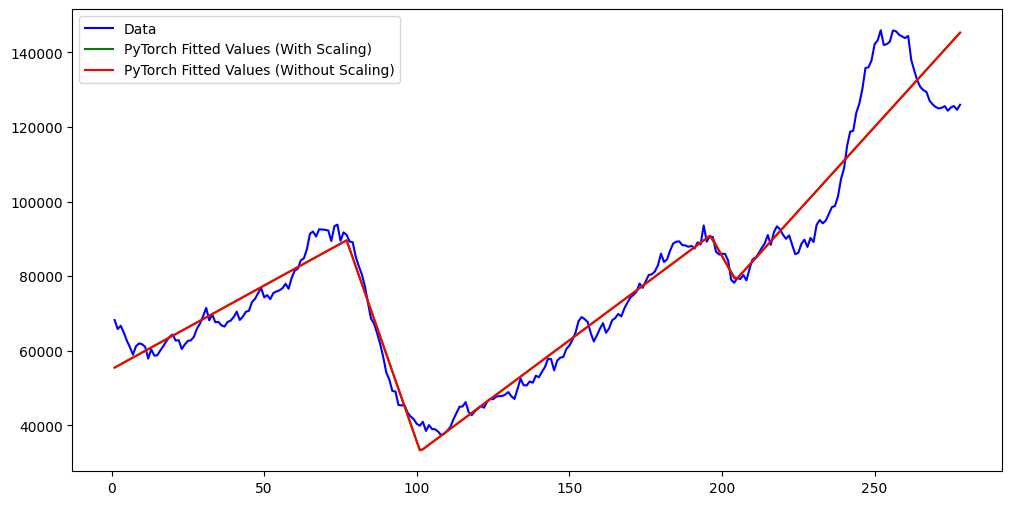

In [13]:
nn_fits_with_scaling = md_nn(x_torch).detach().numpy()
nn_fits_with_scaling_original_scale = (nn_fits_with_scaling * np.std(y_raw)) + np.mean(y_raw)

plt.figure(figsize = (12, 6))
plt.plot(x_raw, y_raw, color = 'blue', label = 'Data')
plt.plot(x_raw, nn_fits_with_scaling_original_scale, color = 'green', label = 'PyTorch Fitted Values (With Scaling)')
plt.plot(x_raw, nn_fits, color = 'red', label = 'PyTorch Fitted Values (Without Scaling)')
plt.legend()
plt.show()

The fit is quite close to what we got by running the code on the original raw data. But the convergence of the algorithm is much faster with scaling. This is why scaling is almost always recommended. 

## MA(1) and AR(1) model fitting via PyTorch

The algorithms from PyTorch can also be used to fit classical time series models. Here we illustrate how to fit MA(1) and AR(1) models.

We will use the varve dataset from Lecture 20. 

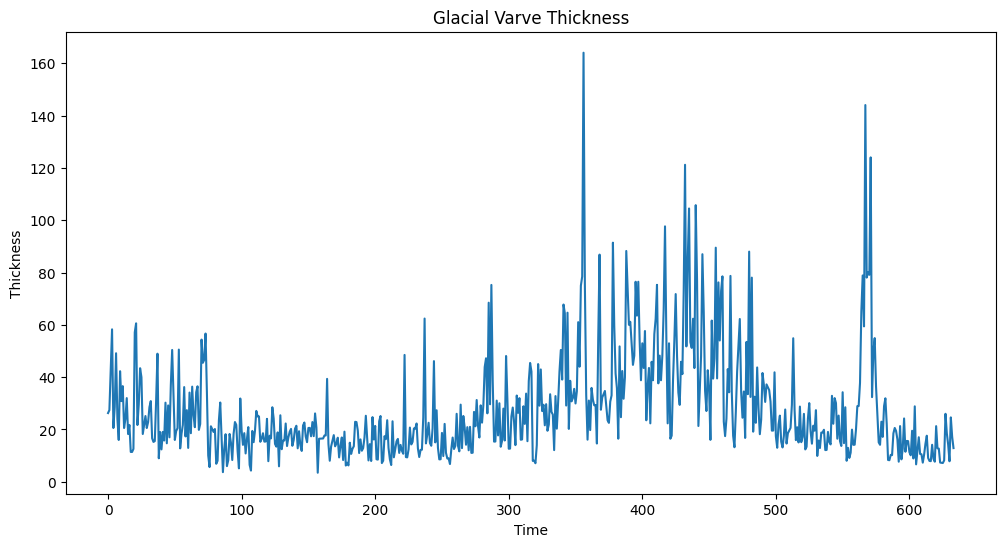

In [14]:
varve_data = pd.read_csv("varve.csv")
yraw = varve_data['x']

plt.figure(figsize = (12, 6))
plt.plot(yraw)
plt.xlabel('Time')
plt.ylabel('Thickness')
plt.title('Glacial Varve Thickness')
plt.show()

In Lecture 20, we took logarithms of this dataset, then differenced, and then fitted the MA(1) model. We will now fit this model (as well as AR(1)) using PyTorch (instead of ARIMA).  

First let us recall how we fit this using ARIMA. 

In [15]:
ylogdiff = np.diff(np.log(yraw))
mamod_ARIMA = ARIMA(ylogdiff, order=(0, 0, 1)).fit()

print(mamod_ARIMA.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  633
Model:                 ARIMA(0, 0, 1)   Log Likelihood                -440.678
Date:                Fri, 25 Apr 2025   AIC                            887.356
Time:                        10:50:24   BIC                            900.707
Sample:                             0   HQIC                           892.541
                                - 633                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0013      0.004     -0.280      0.779      -0.010       0.008
ma.L1         -0.7710      0.023    -33.056      0.000      -0.817      -0.725
sigma2         0.2353      0.012     18.881      0.0

Below we describe the optimization problem that we need to solve in order to estimate the MA(1) parameters $\mu, \theta, \sigma$. Recall that the MA(1) model is given by
\begin{equation*}
  y_t = \mu + \epsilon_t + \theta \epsilon_{t-1}
\end{equation*}
with $\epsilon_t \overset{\text{i.i.d}}{\sim} N(0, \sigma^2)$. The likelihood is $f_{y_1, \dots, y_n}(y_1, \dots, y_n)$ can be written in terms of the covariance matrix of $y_1, \dots, y_n$. This is somewhat complicated. A simplification trick is to condition on $\epsilon = 0$, i.e., one attempts to write the conditional likelihood: 
\begin{equation*}
   f_{y_1, \dots, y_n \mid \epsilon_0 = 0}(y_1, \dots, y_n). 
\end{equation*}
This likelihood is much simpler to write by breaking it down as
\begin{equation*}
  f_{y_1 \mid \epsilon_0 = 0}(y_1) f_{y_2 \mid y_1, \epsilon_0 = 0}(y_2) f_{y_3 \mid y_1, y_2, \epsilon_0 = 0}(y_3) \dots f_{y_n \mid y_1, \dots, y_{n-1}, \epsilon_0 = 0}(y_n)
\end{equation*}
Each of the terms above can be written explicitly. Let $\hat{\epsilon}_1 = y_1 - \mu$ and, for $t = 2, \dots, n$, 
\begin{equation*}
    \hat{\epsilon}_t = y_t- \mu - \theta \hat{\epsilon}_{t-1} 
\end{equation*}
Then 
\begin{equation*}
   f_{y_1 \mid \epsilon_0 = 0}(y_1) = \frac{1}{\sqrt{2 \pi} \sigma} \exp \left(-\frac{(y_1 - \mu)^2}{2 \sigma^2} \right)
\end{equation*}
and
\begin{align*}
  f_{y_t \mid y_1, \dots, y_{t-1}, \epsilon = 0}(y_t) &= f_{y_t \mid \epsilon_1 = \hat{\epsilon}_1, \epsilon_2 = \hat{\epsilon}_2, \dots, \epsilon_{t-1} = \hat{\epsilon}_{t-1}, \epsilon_0 = 0}(y_t) \\
  &= f_{\epsilon_t}(y_t - \mu - \theta \hat{\epsilon}_{t-1}) = \frac{1}{\sqrt{2 \pi} \sigma} \exp \left(-\frac{1}{2 \sigma^2} (y_t - \mu - \theta \hat{\epsilon}_{t-1})^2 \right). 
\end{align*}
Thus the conditional likelihood given $\epsilon_0 = 0$ is given by
\begin{align*}
   \frac{1}{\sqrt{2 \pi} \sigma} \exp \left(-\frac{(y_1 - \mu)^2}{2 \sigma^2} \right) \left[\prod_{t=2}^n \frac{1}{\sqrt{2 \pi} \sigma} \exp \left(-\frac{1}{2 \sigma^2} (y_t - \mu - \theta \hat{\epsilon}_{t-1})^2 \right) \right] = \frac{1}{\sqrt{2 \pi} \sigma} \exp \left(-\frac{\hat{\epsilon}_1^2}{2 \sigma^2} \right) \left[\prod_{t=2}^n \frac{1}{\sqrt{2 \pi} \sigma} \exp \left(-\frac{\hat{\epsilon}_t^2}{2 \sigma^2}  \right) \right]
\end{align*}
so that the negative log-likelihood  becomes:
\begin{align*}
   \frac{n}{2} \log (2 \pi) + 0.5 \sum_{t=1}^n \left(\log \sigma^2 + \frac{\hat{\epsilon}_t^2}{\sigma^2} \right). 
\end{align*}


In [16]:
class MA1Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.mu = nn.Parameter(torch.tensor(0.0))  # initialized at 0
        self.theta = nn.Parameter(torch.tensor(0.0))  # initialized at 0
        self.log_sigma = nn.Parameter(torch.tensor(0.0))  # log(sigma)

    def forward(self, y):
        n = len(y)
        eps_list = []
        eps_prev = y[0] - self.mu  # ε_0
        eps_list.append(eps_prev)
        for t in range(1, n):
            eps_t = y[t] - self.mu - self.theta * eps_prev
            eps_list.append(eps_t)
            eps_prev = eps_t  
        eps = torch.stack(eps_list)

        sigma = torch.exp(self.log_sigma)
        nll = (0.5 * n * np.log(2 * np.pi)) + 0.5 * torch.sum(torch.log(sigma**2) + (eps**2) / (sigma**2))
        return nll

In [17]:
ylogdiff_tensor = torch.tensor(ylogdiff, dtype=torch.float32) 

In [18]:
mamod = MA1Model()

In [19]:
optimizer = optim.Adam(mamod.parameters(), lr=0.001)

for epoch in range(4000):
    # Zero gradient
    optimizer.zero_grad()

    # Compute loss
    loss = mamod(ylogdiff_tensor)

    # Compute gradient
    loss.backward()

    # Update parameters
    optimizer.step()

    if epoch % 100 == 0:
        sigma = torch.exp(mamod.log_sigma).item()
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}, mu: {mamod.mu.item():.4f}, "
              f"theta: {mamod.theta.item():.4f}, sigma: {sigma:.4f}")


Epoch 0, Loss: 686.6678, mu: -0.0010, theta: -0.0010, sigma: 0.9990
Epoch 100, Loss: 637.9557, mu: -0.0011, theta: -0.1006, sigma: 0.9050
Epoch 200, Loss: 593.8228, mu: -0.0011, theta: -0.1994, sigma: 0.8229
Epoch 300, Loss: 554.7609, mu: -0.0010, theta: -0.2977, sigma: 0.7518
Epoch 400, Loss: 521.1600, mu: -0.0010, theta: -0.3950, sigma: 0.6909
Epoch 500, Loss: 493.3359, mu: -0.0010, theta: -0.4902, sigma: 0.6394
Epoch 600, Loss: 471.5909, mu: -0.0011, theta: -0.5805, sigma: 0.5968
Epoch 700, Loss: 456.2418, mu: -0.0010, theta: -0.6599, sigma: 0.5624
Epoch 800, Loss: 447.1696, mu: -0.0011, theta: -0.7199, sigma: 0.5359
Epoch 900, Loss: 442.9311, mu: -0.0011, theta: -0.7544, sigma: 0.5167
Epoch 1000, Loss: 441.2652, mu: -0.0011, theta: -0.7682, sigma: 0.5038
Epoch 1100, Loss: 440.6577, mu: -0.0011, theta: -0.7719, sigma: 0.4956
Epoch 1200, Loss: 440.4542, mu: -0.0011, theta: -0.7727, sigma: 0.4907
Epoch 1300, Loss: 440.3932, mu: -0.0011, theta: -0.7728, sigma: 0.4880
Epoch 1400, Loss: 

The following code prints out the estimates given by this code, with the estimates given by the ARIMA function. 

In [20]:
ma1_pars = np.array([mamod.mu.detach().numpy(), 
                     mamod.theta.detach().numpy(), 
                     np.exp(2 * mamod.log_sigma.detach().numpy())]) 
# mu, theta and sigma^2

print(np.column_stack([mamod_ARIMA.params, ma1_pars]))
# the parameter estimates are quite close to each other

[[-0.00125667 -0.00113865]
 [-0.77099236 -0.77283102]
 [ 0.23528045  0.23539422]]


Next let us fit the AR(1) model using PyTorch. Note that the full likelihood in the AR(1) model (stationary case) is given by (see Equation (6) in the notes for Lecture 17): 
\begin{align*}
\frac{\sqrt{1 - \phi_1^2}}{\sqrt{2 \pi}
      \sigma} \exp \left(-\frac{1 - \phi_1^2}{2 \sigma^2} \left(y_1 -
        \frac{\phi_0}{1 - \phi_1} \right)^2 \right) \left(\frac{1}{\sqrt{2 \pi} \sigma}
    \right)^{n-1} \exp \left(-\frac{1}{2 \sigma^2} \sum_{t=2}^n (y_t -
    \phi_0 - \phi_1 y_{t-1})^2 \right). 
\end{align*}


Below we first fit AR(1) using ARIMA, and then fit it by maximizing the log of the likelihood written above. 

In [21]:
armod_ARIMA = ARIMA(ylogdiff, order=(1, 0, 0)).fit()
print(armod_ARIMA.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  633
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -494.562
Date:                Fri, 25 Apr 2025   AIC                            995.124
Time:                        10:52:14   BIC                           1008.475
Sample:                             0   HQIC                          1000.309
                                - 633                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0010      0.015     -0.067      0.946      -0.031       0.029
ar.L1         -0.3970      0.036    -10.989      0.000      -0.468      -0.326
sigma2         0.2793      0.015     18.916      0.0

In [ ]:
class AR1Model(nn.Module):
    def __init__(self):
        super().__init__()
        # Learnable parameters: phi0 (intercept), phi1 (AR coefficient), log_sigma (for positivity)
        self.phi0 = nn.Parameter(torch.tensor(0.0))
        self.phi1 = nn.Parameter(torch.tensor(0.0))
        self.log_sigma = nn.Parameter(torch.tensor(0.0))  # log(sigma) to ensure sigma > 0

    def forward(self, y):
        n = len(y)
        sigma = torch.exp(self.log_sigma)
        phi0 = self.phi0
        phi1 = self.phi1

        if torch.abs(phi1) >= 1:
            return torch.tensor(float("inf")), None

        # Stationary mean of y_1
        y1_mean = phi0 / (1 - phi1)

        # Compute log-likelihood parts
        part1 = -0.5 * n * torch.log(torch.tensor(2 * torch.pi))
        part2 = -n * torch.log(sigma)
        part3 = 0.5 * torch.log(1 - phi1**2)
        part4 = - (1 - phi1**2) / (2 * sigma**2) * (y[0] - y1_mean)**2
        part5 = - (1 / (2 * sigma**2)) * torch.sum((y[1:] - phi0 - phi1 * y[:-1])**2)

        negative_log_likelihood = -(part1 + part2 + part3 + part4 + part5)

        return negative_log_likelihood


In [23]:
# Fit the model
armod = AR1Model()
optimizer = optim.Adam(armod.parameters(), lr=0.001)

for epoch in range(3000):
    # Zero gradient
    optimizer.zero_grad()

    # Compute loss
    loss = armod(ylogdiff_tensor)

    # Compute gradient
    loss.backward()

    # Update parameters
    optimizer.step()
    
    if epoch % 100 == 0:
        print(f"Epoch {epoch}: phi0={armod.phi0.item():.4f}, phi1={armod.phi1.item():.4f}, sigma={torch.exp(armod.log_sigma).item():.4f}, loss={loss.item():.4f}")

Epoch 0: phi0=-0.0010, phi1=0.4990, sigma=0.9990, loss=754.7678
Epoch 100: phi0=-0.0008, phi1=0.3977, sigma=0.9057, loss=708.1990
Epoch 200: phi0=-0.0009, phi1=0.2938, sigma=0.8257, loss=664.1494
Epoch 300: phi0=-0.0010, phi1=0.1895, sigma=0.7572, loss=623.2971
Epoch 400: phi0=-0.0011, phi1=0.0874, sigma=0.6989, loss=586.7548
Epoch 500: phi0=-0.0011, phi1=-0.0099, sigma=0.6502, loss=555.8716
Epoch 600: phi0=-0.0012, phi1=-0.0992, sigma=0.6108, loss=531.7949
Epoch 700: phi0=-0.0011, phi1=-0.1778, sigma=0.5804, loss=514.9111
Epoch 800: phi0=-0.0013, phi1=-0.2431, sigma=0.5587, loss=504.4892
Epoch 900: phi0=-0.0014, phi1=-0.2943, sigma=0.5445, loss=498.8905
Epoch 1000: phi0=-0.0014, phi1=-0.3318, sigma=0.5362, loss=496.2641
Epoch 1100: phi0=-0.0014, phi1=-0.3575, sigma=0.5318, loss=495.1721
Epoch 1200: phi0=-0.0014, phi1=-0.3742, sigma=0.5298, loss=494.7625
Epoch 1300: phi0=-0.0015, phi1=-0.3844, sigma=0.5289, loss=494.6224
Epoch 1400: phi0=-0.0014, phi1=-0.3904, sigma=0.5286, loss=494.57

In [24]:
ar1_pars = np.array([armod.phi0.detach().numpy(), 
                     armod.phi1.detach().numpy(), 
                     np.exp(2 * armod.log_sigma.detach().numpy())])
# mu, theta and sigma^2

print(np.column_stack([armod_ARIMA.params, ar1_pars]))

[[-0.00102183 -0.00127035]
 [-0.39696193 -0.39696154]
 [ 0.27927876  0.27927745]]


It is possible to extend these methods to fit AR($p$) and MA($q$) for more general $p$ and $q$ using PyTorch. The PyTorch seems to work just as well as ARIMA. In the above, the PyTorch seems to take much longer time but this is only because we are running the method for a few thousand epochs. The actual convergence seems to have happened much earlier. 